['config.cfg']

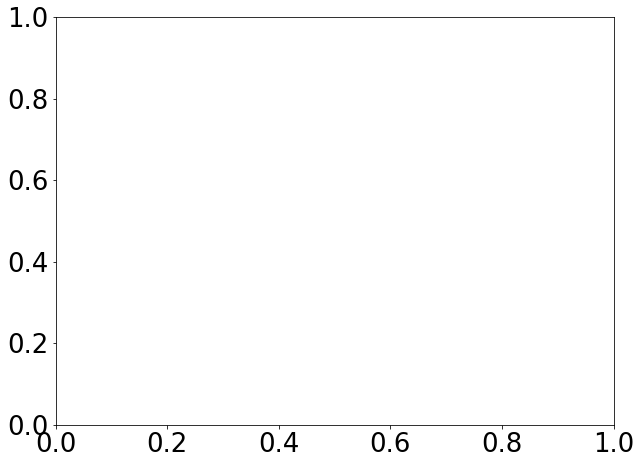

In [1]:
#Importing all the libraries

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib
import csv
import ortools
import math
import configparser
import datetime
import time
from geopy.geocoders import Nominatim
matplotlib.rc('xtick', labelsize=26) 
matplotlib.rc('ytick', labelsize=26) 
plt.rcParams['font.size'] = '26'
plt.rcParams['figure.figsize'] = (10,7.5)
fig, ax = plt.subplots()
fig.set_size_inches(10, 7.5)


configParser = configparser.RawConfigParser()   
configFilePath = 'config.cfg'
configParser.read(configFilePath)

In [2]:
# Program to find most frequent
# element in a list
 
from collections import Counter
 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]



In [3]:
#File paths
configParser.read(configFilePath)
customer_dir=configParser.get('file-paths','customer_dir')
geolocation_dir=configParser.get('file-paths','geolocation_dir')
seller_dir = configParser.get('file-paths','seller_dir')
order_dir= configParser.get('file-paths','order_dir')
order_item_dir=configParser.get('file-paths','order_item_dir')


#Creating dataframes
customer_df=pd.read_csv(customer_dir)
location_df=pd.read_csv(geolocation_dir)
seller_df=pd.read_csv(seller_dir)
order_df=pd.read_csv(order_dir)
order_item_df=pd.read_csv(order_item_dir)

# location_df=location_df[location_df['geolocation_state']=='SP']
state_or_city=configParser.get('dataset-generation','state_or_city')
city_dataset= configParser.get('dataset-generation','city')
state_dataset= configParser.get('dataset-generation','state')
equal_or_not=int(configParser.get('dataset-generation','equal_to'))

if state_or_city=='state':
  if equal_or_not==1:
    location_df=location_df[location_df['geolocation_state']==state_dataset]
  else:
    location_df=location_df[location_df['geolocation_state']!=state_dataset]
else:
  if equal_or_not==1:
    location_df=location_df[location_df['geolocation_city']==city_dataset]
  else:
    location_df=location_df[location_df['geolocation_city']!=city_dataset]


location_df=location_df.drop_duplicates('geolocation_zip_code_prefix')


training_data_percent=int(configParser.get('dataset-generation','training_data_percent'))
club_num_dates=int(configParser.get('dataset-generation','club_num_dates'))

def club_date(dt,club_num_dates):
  return pd.datetime(dt.year,dt.month,int(dt.day/club_num_dates)*club_num_dates+1) 




#Dividing training and testing data
#order_df Datefram having data related to orders
order_df=order_df[order_df['order_status']=='delivered']
order_df=order_df[order_df['order_delivered_customer_date'].notna()]
order_df['order_delivered_customer_date']=pd.to_datetime(order_df['order_delivered_customer_date'])
order_df['order_delivered_customer_date']=order_df['order_delivered_customer_date'].dt.date
#Clubbing multiple dates into one, because the data for one date is too small
order_df['order_delivered_customer_date']=order_df['order_delivered_customer_date'].map(lambda x: club_date(x,club_num_dates))
order_df=order_df.sort_values("order_delivered_customer_date")
order_df=order_df.reset_index()



overall_customer_df=pd.merge(customer_df,order_df,on='customer_id')
overall_customer_loc_df=pd.merge(overall_customer_df,location_df,left_on='customer_zip_code_prefix' ,right_on='geolocation_zip_code_prefix')

#Dividing training data and testing data
start_training_date=order_df["order_delivered_customer_date"].iloc[int((10+training_data_percent)/100*len(order_df.index))]
end_training_date=order_df["order_delivered_customer_date"].iloc[int(0.1*len(order_df.index))]
training_order_df=order_df[order_df['order_delivered_customer_date']<=start_training_date]
training_order_df=training_order_df[order_df['order_delivered_customer_date']>=end_training_date]
num_training_days=training_order_df['order_delivered_customer_date'].nunique()


training_customer_df=pd.merge(customer_df,training_order_df,on='customer_id')
training_customer_df=training_customer_df.drop_duplicates('customer_unique_id')
temp_df=pd.merge(order_item_df,training_order_df,on='order_id')
training_seller_df=pd.merge(seller_df,temp_df,on='seller_id')
training_seller_df=training_seller_df.drop_duplicates('seller_zip_code_prefix')


training_customer_loc_df = pd.merge(training_customer_df, location_df,left_on = 'customer_zip_code_prefix' ,right_on='geolocation_zip_code_prefix')
training_seller_loc_df = pd.merge(training_seller_df, location_df,left_on = 'seller_zip_code_prefix' ,right_on='geolocation_zip_code_prefix')

training_customer_loc_df.rename(columns = {'customer_city':'city'}, inplace = True)
training_seller_loc_df.rename(columns = {'seller_city':'city'}, inplace = True)
   
   


training_customer_locations=training_customer_loc_df[['geolocation_lat','geolocation_lng','city']]
training_seller_locations=training_seller_loc_df[['geolocation_lat','geolocation_lng','city']]
training_combined_locations=pd.concat([training_customer_locations,training_seller_locations])







/var/folders/yl/h93qljb15x170kd7fypdjht40000gn/T/ipykernel_85333/521146982.py:42: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime(dt.year,dt.month,int(dt.day/club_num_dates)*club_num_dates+1)
/var/folders/yl/h93qljb15x170kd7fypdjht40000gn/T/ipykernel_85333/521146982.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  training_order_df=training_order_df[order_df['order_delivered_customer_date']>=end_training_date]


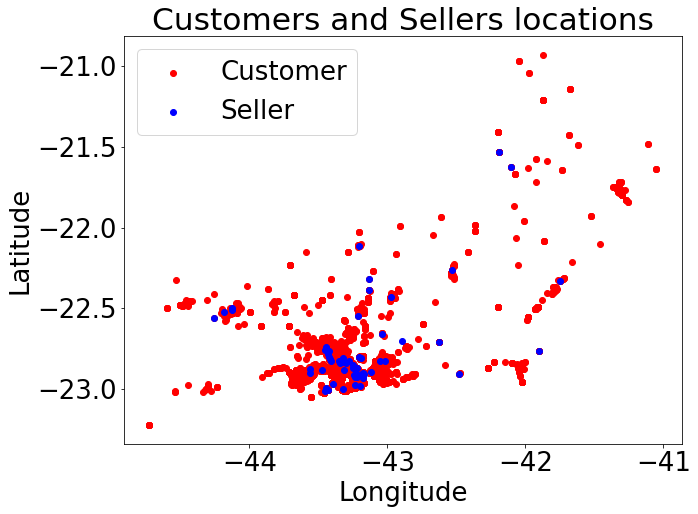

2910
Number of customers = 2849
Number of sellers = 61
    label  freq          x          y
0       0   136 -22.598140 -44.276269
3       1   969 -22.930471 -43.223575
10      2    97 -22.400120 -41.872487
4       3   582 -22.806112 -43.377150
7       4    56 -21.413064 -41.970317
11      5    73 -21.765921 -41.310710
5       6   414 -22.932277 -43.547899
2       7   258 -22.843372 -43.004926
1       8   115 -22.400950 -43.131266
6       9    86 -22.869927 -42.127809
8      10    80 -22.493258 -43.720808
9      11    44 -22.178499 -42.512987


Text(0.5, 1.0, 'Customers, Sellers and Warehouses locations')

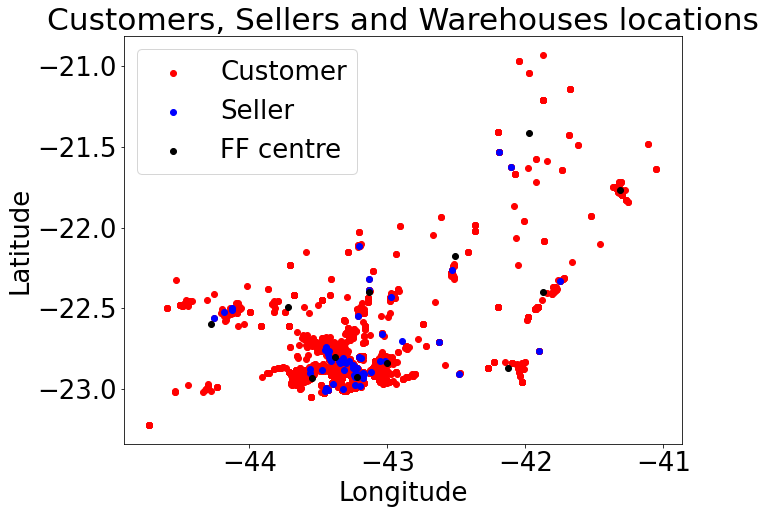

In [4]:
#Creating FFCs using customer and seller data locations

lis=['geolocation_lat','geolocation_lng']
X=training_customer_locations[lis].values
X1=np.transpose(X)

plt.scatter(X1[1],X1[0],color='Red',label='Customer')

X=training_seller_locations[lis].values
X1=np.transpose(X)
plt.scatter(X1[1],X1[0],color='Blue',label='Seller')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Customers and Sellers locations')
plt.show()
X=training_combined_locations[lis].values
print(len(training_combined_locations.index))
print("Number of customers = " + str(len(training_customer_locations.index)))
print("Number of sellers = " + str(len(training_seller_locations.index)))


configParser.read(configFilePath)
num_ffc_center=int(configParser.get('dataset-generation','num_ffc_center'))
kmeans=KMeans(n_clusters=num_ffc_center,random_state=0).fit(X)
centre=kmeans.cluster_centers_
label=pd.DataFrame(kmeans.labels_,columns=['label'])
label['freq']=label.groupby('label')['label'].transform('count')
label=label.drop_duplicates('label')
label=label.reset_index(drop=True)
label=label.sort_values('label')
X1=np.transpose(centre)
label['x']=X1[0]
label['y']=X1[1]
print(label)

lis=['geolocation_lat','geolocation_lng']

X=training_customer_locations[lis].values
X1=np.transpose(X)

plt.scatter(X1[1],X1[0],color='Red',label='Customer')

X=training_seller_locations[lis].values
X1=np.transpose(X)
plt.scatter(X1[1],X1[0],color='Blue',label='Seller')
X1=np.transpose(centre)
plt.scatter(X1[1],X1[0],color='Black',label='FF centre')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Customers, Sellers and Warehouses locations')





In [5]:
testing_order_df=order_df[order_df['order_delivered_customer_date']>end_training_date]
testing_customer_df=pd.merge(customer_df,testing_order_df,on='customer_id')
testing_customer_df=testing_customer_df.drop_duplicates('customer_unique_id')
testing_customer_loc_df = pd.merge(testing_customer_df, location_df,left_on = 'customer_zip_code_prefix' ,right_on='geolocation_zip_code_prefix')

testing_seller_df=pd.merge(seller_df,temp_df,on='seller_id')
testing_seller_df=testing_seller_df.drop_duplicates('seller_zip_code_prefix')
testing_seller_loc_df = pd.merge(testing_seller_df, location_df,left_on = 'seller_zip_code_prefix' ,right_on='geolocation_zip_code_prefix')

print(len(testing_customer_loc_df.index))


# removing outliers
lat_mean=training_combined_locations['geolocation_lat'].mean()
lat_std= training_combined_locations['geolocation_lat'].std()
testing_customer_loc_df=testing_customer_loc_df[(testing_customer_loc_df['geolocation_lat']-lat_mean)< 3*lat_std]
testing_customer_loc_df=testing_customer_loc_df[(testing_customer_loc_df['geolocation_lat']-lat_mean)> -3*lat_std]


lng_mean=training_combined_locations['geolocation_lng'].mean()
lng_std= training_combined_locations['geolocation_lng'].std()
testing_customer_loc_df=testing_customer_loc_df[(testing_customer_loc_df['geolocation_lng']-lng_mean)< 3*lng_std]
testing_customer_loc_df=testing_customer_loc_df[(testing_customer_loc_df['geolocation_lng']-lng_mean)> -3*lng_std]


testing_customer_loc_df=testing_customer_loc_df.reset_index(drop=True)

print(len(testing_customer_loc_df.index))


lis=['geolocation_lat','geolocation_lng']
prediction_array=np.array(kmeans.predict(testing_customer_loc_df[lis].values))
unique, counts = np.unique(prediction_array, return_counts=True)
testing_customer_loc_df['ffc_index']=prediction_array
testing_customer_loc_df=testing_customer_loc_df.sort_values('order_delivered_customer_date')




10601
10144


In [6]:
# Finding maximum and minimum capacity of a warehouse for training data

prediction_array=np.array(kmeans.predict(training_customer_loc_df[lis].values))
unique, counts = np.unique(prediction_array, return_counts=True)
training_customer_loc_df['ffc_index']=prediction_array

training_customer_group_date = training_customer_loc_df.groupby(['ffc_index','order_delivered_customer_date'])['order_id'].count()

configParser.read(configFilePath)
quantile_capacity=float(configParser.get('dataset-generation','qauntile_capacity'))

training_customer_group_date=pd.DataFrame({'count':training_customer_group_date}).reset_index()
training_customer_group_date = training_customer_group_date.groupby(['ffc_index'])['count'].quantile(quantile_capacity)
training_customer_group_date = pd.DataFrame({'cap':training_customer_group_date}).reset_index()

training_customer_group_date['min_cap'] = 0.5 * training_customer_group_date['cap']
training_customer_group_date['max_cap'] = 1.5 * training_customer_group_date['cap']
training_customer_group_date=training_customer_group_date.sort_values('ffc_index')
max_cap=training_customer_group_date['max_cap'].values
min_cap=training_customer_group_date['min_cap'].values


Number of Drivers: 85


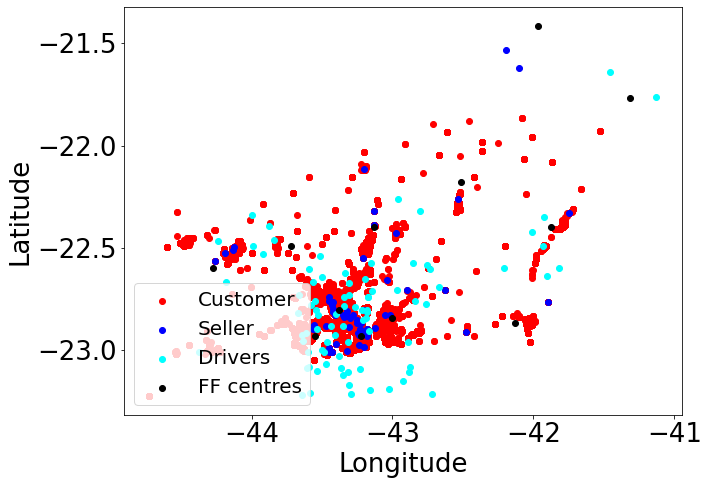

(array([[-23.01093976, -44.37620058],
        [-23.10382253, -43.53193484],
        [-22.96071479, -43.31318265],
        [-23.02934281, -43.3827151 ],
        [-23.00967537, -43.59954664],
        [-23.0823691 , -43.59063756],
        [-22.92929865, -43.64496161],
        [-22.95793142, -43.63667181],
        [-23.00125685, -43.4988753 ],
        [-23.09401255, -43.23345785],
        [-23.22083035, -43.6439321 ],
        [-22.92632191, -43.40858661],
        [-23.19705306, -43.15745123],
        [-22.91591412, -43.61675882],
        [-23.08790432, -43.60492075],
        [-23.12426195, -43.34949253],
        [-23.17321911, -43.30990469],
        [-23.21007115, -43.58593908],
        [-22.95895726, -43.46551766],
        [-23.08933883, -43.36287409],
        [-23.07030744, -43.47388728],
        [-23.21692404, -43.2944162 ],
        [-22.90909838, -43.16313882],
        [-23.00892797, -43.48871578],
        [-23.10764206, -43.31343377],
        [-23.18954458, -43.02729659],
        [-23

In [7]:


import random
def driver_generation(val):

  # Creating drivers through grid formation

  X=training_combined_locations[lis].values
  X=training_combined_locations[['geolocation_lat','geolocation_lng']].values
  X_city=training_combined_locations[['city']].values
  X1=np.transpose(X)
  min_long=np.amin(X1[0])
  max_long=np.amax(X1[0])

  min_lat=np.amin(X1[1])
  max_lat=np.amax(X1[1])

  configParser.read(configFilePath)
  prop_constant_driver_customer=float(configParser.get('dataset-generation','prop_constant_driver_customer'))
  grid_length=int(configParser.get('dataset-generation','grid_length'))
  grid_width=int(configParser.get('dataset-generation','grid_width'))
  prop_constant_lower_range=float(configParser.get('dataset-generation','prop_constant_lower_range'))
  prop_constant_higher_range=float(configParser.get('dataset-generation','prop_constant_upper_range'))

  # random.seed(int(configParser.get('dataset-generation','Random_seed_value')))
  random.seed(val)

  grid_size=[grid_length,grid_width]
  drivers=[[],[]]
  driver_city=[]
  sum_customer=0
  sum_driver=0



  check_df=pd.DataFrame(columns=['city','suburb','municipality','county','city_district','state_district'])
  

  for i in range(grid_size[0]):
    left_long=min_long+(max_long-min_long)/grid_size[0]*i
    right_long=min_long+(max_long-min_long)/grid_size[0]*(i+1)
    ind1=X1[0]>=left_long
    ind2=X1[0]<=right_long

    for j in range(grid_size[1]):
      up_lat=min_lat+(max_lat-min_lat)/grid_size[1]*(j+1)
      down_lat=min_lat+(max_lat-min_lat)/grid_size[1]*j
      ind3=X1[1]>=down_lat
      ind4=X1[1]<=up_lat
      ind=ind1 & ind2 & ind3 & ind4
     

      num_customers=np.count_nonzero(ind)/num_training_days
      num_drivers=num_customers/prop_constant_driver_customer
      random_constant=random.uniform(prop_constant_lower_range,prop_constant_higher_range)
      num_drivers=int(num_drivers*random_constant)

      if num_drivers==0:
        continue
      # print(ind)
      X_city_temp=(X_city[ind])
      X_city_temp=(np.array(X_city_temp)).flatten()
      for k in range(num_drivers):
        drivers[0].append(random.uniform(left_long,right_long))
        drivers[1].append(random.uniform(down_lat,up_lat))
        driver_city.append(most_frequent(X_city_temp))
        lat=drivers[0][-1]
        lng=drivers[1][-1]
      

      sum_driver=sum_driver+num_drivers
      sum_customer=sum_customer+num_customers
  drivers=np.array(drivers)

  print("Number of Drivers:",len(drivers[0]))
  new_drivers=np.transpose(drivers)
  


  fig, ax = plt.subplots()
  # fig.set_size_inches(10, 7.5)


  
  tempdf=testing_customer_loc_df
  # tempdf=tempdf[tempdf['geolocation_lng']<-40]
  X=tempdf[lis].values
  X1=np.transpose(X)
  # ax.set_ylim([-33, -26.5])
  plt.scatter(X1[1],X1[0],color='Red',label='Customer')
  X=testing_seller_loc_df[lis].values
  X1=np.transpose(X)
  plt.scatter(X1[1],X1[0],color='Blue',label='Seller')
  X1=drivers
  plt.scatter(X1[1],X1[0],color='Cyan',label='Drivers')
  X1=np.transpose(centre)
  plt.scatter(X1[1],X1[0],color='Black',label='FF centres')
  plt.legend(loc='lower left',prop={'size':20})
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  # plt.title('Customers, Sellers, Warehouse and Agents locations')



  # plt.savefig("Plots/Coordinate Plots/"+state_dataset+".pdf")
  plt.show()
  plt.close()




  return new_drivers,driver_city



driver_generation(12)






In [8]:

# x1 = 1+"s"+[]+()
#Using max flow for the Vanilla Distribution of Drivers to the warehouse
import networkx as nx
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))


configParser.read(configFilePath)
prop_constant_driver_customer=float(configParser.get('dataset-generation','prop_constant_driver_customer'))

upper_cap=max_cap/prop_constant_driver_customer
lower_cap=min_cap/prop_constant_driver_customer
lower_cap=lower_cap.astype(int)
upper_cap=upper_cap.astype(int)
upper_cap=np.array(upper_cap)
lower_cap=np.array(lower_cap)
print(lower_cap)
lower_cap[lower_cap<=0]=1
print(lower_cap)

print(np.sum(upper_cap),np.sum(lower_cap))







def flow_with_max_capacity(driver_loc,centre):
  G = nx.DiGraph()
  num_variables=len(centre)+len(driver_loc)
  for i in range(len(driver_loc)):
    G.add_edge(1,i+2,capacity=1,weight=0)


  for i in range(len(centre)):
    G.add_edge(len(driver_loc)+1+(i+1),num_variables+2,capacity=int(upper_cap[i]),weight=0)



  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      dis=(driver_loc[i][0]-centre[j][0])**2+(driver_loc[i][1]-centre[j][1])**2
      G.add_edge(i+2,len(driver_loc)+1+(j+1),capacity=1,weight=int(dis*1000))

  mincostFlow = nx.max_flow_min_cost(G, 1, num_variables+2)
  mincost = nx.cost_of_flow(G, mincostFlow)
  print(mincost)
  from networkx.algorithms.flow import maximum_flow
  maxFlow = maximum_flow(G, 1, num_variables+2)[1]
  print(nx.cost_of_flow(G, maxFlow))


  print(nx.maximum_flow_value(G,1,num_variables+2))
  driver_df=pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df['ffc_index']=-1
  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      if abs(mincostFlow[i+2][len(driver_loc)+(j+2)]-1)<0.1:
        driver_df.at[i,'ffc_index']=j
  return driver_df


from ortools.graph import pywrapgraph

def flow_with_maxmin_capacity(driver_loc,centre):

  # Instantiate a SimpleMinCostFlow solver.
  # Using min-max flow for the Vanilla Distribution of Drivers to the warehouse
  num_variables=len(centre)+len(driver_loc)
  min_cost_flow = pywrapgraph.SimpleMinCostFlow()
  for i in range(len(driver_loc)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(1,i+2,1,0)

  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      dis=(driver_loc[i][0]-centre[j][0])**2+(driver_loc[i][1]-centre[j][1])**2
      min_cost_flow.AddArcWithCapacityAndUnitCost(i+2,len(driver_loc)+1+(j+1),1,int(dis*1000))


  for i in range(len(centre)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(len(driver_loc)+1+(i+1),num_variables+2,int(upper_cap[i])-int(lower_cap[i]),0)


  for i in range(0,len(centre)):
    min_cost_flow.SetNodeSupply(len(driver_loc)+1+(i+1),-int(lower_cap[i]))

  source_supply=int(len(driver_loc))
  sink_supply=int(len(driver_loc)-np.sum(lower_cap))

  min_cost_flow.SetNodeSupply(1,source_supply)
  min_cost_flow.SetNodeSupply(num_variables+2,-sink_supply)


  for i in range(0,len(driver_loc)):
    min_cost_flow.SetNodeSupply(i+2,0)


  if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
      print('Minimum cost:', min_cost_flow.OptimalCost())
      print('')
      print('  Arc    Flow / Capacity  Cost')
      for i in range(min_cost_flow.NumArcs()):
        if min_cost_flow.Flow(i)!=0:
          cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
          print('%1s -> %1s   %3s  / %3s       %3s' % (
              min_cost_flow.Tail(i),
              min_cost_flow.Head(i),
              min_cost_flow.Flow(i),
              min_cost_flow.Capacity(i),
              cost))
  else:
    print('There was an issue with the min cost flow input.')

  driver_df1=pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df1['ffc_index']=-1
  for i in range(min_cost_flow.NumArcs()):
    if min_cost_flow.Flow(i)!=0 and min_cost_flow.Tail(i)!=1 and min_cost_flow.Head(i)!=(num_variables+2):
      tail=min_cost_flow.Tail(i)
      head=min_cost_flow.Head(i)
      driver_df1.at[tail-2,'ffc_index']=head-len(driver_loc)-2

  return driver_df1








[ 3 24  2 13  1  1 11  6  3  2  2  1]
[ 3 24  2 13  1  1 11  6  3  2  2  1]
211 69


In [9]:
#Fair Clustering - LPP contstraints and Cplex

sys.path.append('/content/drive/MyDrive/BTP')
from cplex import Cplex
from lp_tools2 import *

configParser.read(configFilePath)
fair_distance=int(configParser.get('fairness-constraint','fair_distance'))
alpha_fair =float(configParser.get('fairness-constraint','alpha_fair'))
  


def fair_clustering(dataset, centres, fairness_type = 0):

  # Step 1: 	Create an instance of Cplex 
  problem = Cplex()

  # Step 2: 	Declare that this is a minimization problem
  problem.objective.set_sense(problem.objective.sense.minimize)

  # Step 3.   Declare and  add variables to the model. The function
  #           prepare_to_add_variables (dataset, centres) prepares all the
  #           required information for this stage.
  #
  #    objective: a list of coefficients (float) in the linear objective function
  #    lower bound: a list of floats containing the lower bounds for each variable
  #    upper bound: a list of floats containing the upper bounds for each variable
  #    variable_names: a list of strings that contains the name of the variables

  objective, lower_bound, upper_bound, variable_names, P,C = prepare_to_add_variables(dataset, centres)
  problem.variables.add(
      obj = objective,
      lb = lower_bound,
      ub = upper_bound,
      names = variable_names
     
    )

  # Step 4.   Declare and add constraints to the model.
  #           There are few ways of adding constraints: row wise, col wise and non-zero entry wise.
  #           Assume the constraint matrix is A. We add the constraints non-zero entry wise.
  #           The function prepare_to_add_constraints(dataset, centres)
  #           prepares the required data for this step.
  #
  #  coefficients: Three tuple containing the row number, column number and the value of the constraint matrix
  #  senses: a list of strings that identifies whether the corresponding constraint is
  #          an equality or inequality. "E" : equals to (=), "L" : less than (<=), "G" : greater than equals (>=)
  #  rhs: a list of floats corresponding to the rhs of the constraints.
  #  constraint_names: a list of string corresponding to the name of the constraint
 
  rhs, senses, row_names, coefficients = prepare_to_add_constraints(dataset, centres, upper_cap,lower_cap, P,C, alpha_fair,fair_distance,fairness_type,)
  print("NUM_constraints",len(senses))
  problem.linear_constraints.add(
      rhs = rhs,
      senses = senses,
      names = row_names
    )
  problem.linear_constraints.set_coefficients(coefficients)

  # Step 5.	Solve the problem
  problem.solve()

  result = {
    "status": problem.solution.get_status(),
    "success": problem.solution.get_status_string(),
    "objective": problem.solution.get_objective_value(),
    "assignment": problem.solution.get_values(),
  }

  return result









ModuleNotFoundError: No module named 'lp_tools2'

In [ ]:

#Income Distribution Graph for Warehouses

configParser.read(configFilePath)

def income_graph(incomes):
  fig, ax = plt.subplots()
  x = np.arange(len(incomes))
  plt.rcParams.update({'font.size': 14})
  
  ax.bar(x,sorted(incomes),np.full(len(incomes),0.5))
  plt.ylabel('Number of Deliveries')
  plt.xlabel('Drivers IDs')

  plt.show()

def income_graph2(incomes):
  fig, ax = plt.subplots()
  x = np.arange(len(incomes))
  plt.rcParams.update({'font.size': 14})
  incomes=list(incomes)
  incomes.sort(reverse=True)
  plt.scatter(x,incomes)
  plt.ylabel('Number of Deliveries')
  plt.xlabel('Driver IDs')
  plt.show()

def box_plot(income_2d,city_lis):
  fig, ax = plt.subplots()
  plt.boxplot(income_2d)
  ax.set_xticklabels(city_lis,rotation='vertical')
  plt.ylabel('Number of Deliveries')
  plt.ylim((0,1000))
  ax.set_ylim([0, 700])
  plt.show()
  

def scatter_income(driver_income_df,fair_type):
  fig, ax = plt.subplots()
  fig.set_size_inches(13, 9)
  configParser.read(configFilePath)


  diff_num=int(configParser.get('results-parameter','diff_num'))
  driver_income_df=driver_income_df.sort_values('total_income')
  driver_income_df=driver_income_df.reset_index()

  df_len=len(driver_income_df.index)
  low_list=[0,45,90,135]
  high_list=[45,90,135,100000]
  colors=['red','orange','green','blue']

  for i in range(diff_num):
    # low_val=driver_income_df['total_income'].quantile((1/diff_num)*i)
    # high_val=driver_income_df['total_income'].quantile(min(1,1/diff_num*(i+1)))
    low_val=low_list[i]
    high_val=high_list[i]
    print(low_val,high_val)
    ind1=(driver_income_df['total_income']<=high_val)
    ind2=(driver_income_df['total_income']>low_val)
    tempo_df=driver_income_df[ind1 & ind2]

    label_string=str(low_val)
    if i==3:
      label_string=label_string+"+"
    else:
      label_string=label_string+" - "+str(high_val)
    

    # print(low_len,len(driver_income_df.index))

    # low_income=round(driver_income_df.iloc[low_len]['total_income'],2)
    # high_income=round(driver_income_df.iloc[high_len]['total_income'],2)
    plt.scatter(tempo_df['geolocation_lng'],tempo_df['geolocation_lat'],color=colors[i],label=label_string)
  # income_lis=driver_income_df['total_income'].values
  # lat_lis=driver_income_df['geolocation_lat'].values
  # lng_lis=driver_income_df['geolocation_lng'].values
  # income_lis=np.round(income_lis,1)
  # for i,txt in enumerate(income_lis):
  #   plt.annotate(txt,(lng_lis[i],lat_lis[i]))
  plt.legend(loc='upper left',prop={'size':20})
  plt.xlabel('Longitude',fontsize='26')
  plt.ylabel('Latitude',fontsize='26')

  if fair_type=="fair_algo":
    plt.savefig("Plots/Scatter Plots/"+state_dataset+"_result.pdf")
  else:
    plt.savefig("Plots/Scatter Plots/"+state_dataset+"_motivation.pdf")
  print(driver_income_df['total_income'].values)
  

  plt.show()
    


def lorenz(arrs,name_dis,colors):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    import matplotlib.pyplot as plt1
    fig, ax = plt1.subplots()
    fig.set_size_inches(10, 7.5)
    plt1.rcParams['font.size'] = '26'
    plt1.rcParams['figure.figsize'] = (10,7.5)
    

    for i in range(len(arrs)):
      arr=arrs[i]
      arr=np.array(arr)
      arr=np.sort(arr)
      plt.rcParams.update({'font.size': 14})
      scaled_prefix_sum = arr.cumsum() / arr.sum()*100
      # this prepends the 0 value (because 0% of all people have 0% of all wealth)
      lorenz_cruve= np.insert(scaled_prefix_sum, 0, 0)
      # we need the X values to be between 0.0 to 1.0

      plt1.plot(np.linspace(0.0, 100.0, lorenz_cruve.size), lorenz_cruve,label=name_dis[i],color=colors[i])
    
    plt1.plot([0,100],[0,100],color='Black',linestyle='--')
    plt1.legend(loc='upper left',prop={'size':20})
   
    plt1.xlabel('% of all drivers',fontsize=26)
    plt1.ylabel('% of total deliveries',fontsize=26)
    if len(name_dis)==2:
      plt1.savefig("Plots/Lorenz Curves/"+state_dataset+"_motivation.pdf")
    else:
      plt1.savefig("Plots/Lorenz Curves/"+state_dataset+"_result.pdf")



    

def average_distance(driver_dist,label):   
    distance_warehouse_driver_df = pd.merge(driver_dist, label,left_on = 'ffc_index' ,right_on='label')
    dist1=0.0
    for i in range(len(distance_warehouse_driver_df)):
        dist1 = dist1 +math.sqrt((distance_warehouse_driver_df.loc[i].at["geolocation_lat"] - distance_warehouse_driver_df.loc[i].at["x"])**2 + (distance_warehouse_driver_df.loc[i].at["geolocation_lng"] - distance_warehouse_driver_df.loc[i].at["y"])**2)
    return round(dist1/len(distance_warehouse_driver_df),2)


    

def gini_index(incomes):
  driver_income=np.array(incomes)
  driver_income=np.sort(driver_income)
  integer_array=np.array([(i+1) for i in range(len(driver_income))])
  driver_income=driver_income*750
  gini_index=2*(np.dot(driver_income,integer_array))/(len(driver_income)*(np.sum(driver_income))) - 1 -1/(len(driver_income))
  
  return round(gini_index,3)

def inequality(df,date_index):
  df['driver_index']=np.arange(len(df.index))
  

  
  driver_assign = df.groupby('ffc_index')['geolocation_lat'].count()
  driver_assign=pd.DataFrame({'num_drivers':driver_assign}).reset_index()
  for i in range(len(centre)):
    if i not in driver_assign['ffc_index'].values:
      driver_assign.loc[len(driver_assign.index)]=[i,0]



  driver_assign=driver_assign.sort_values('ffc_index')
  driver_assign['min_cap']=lower_cap
  driver_assign['max_cap']=upper_cap

  combined=False
  testing_customer_group_date = testing_customer_loc_df.groupby(['ffc_index','order_delivered_customer_date'])['order_id'].count()
  testing_customer_group_date = pd.DataFrame({'num_delivery_per_date':testing_customer_group_date}).reset_index()

  dates=testing_customer_group_date['order_delivered_customer_date'].unique()
  testing_customer_group_date=testing_customer_group_date[testing_customer_group_date['order_delivered_customer_date']==dates[date_index]]


  my_df = pd.merge(testing_customer_group_date, driver_assign,on='ffc_index',how='right')
  my_df['income_warehouse_driver'] = my_df['num_delivery_per_date'] / my_df['num_drivers']
  my_df.loc[~np.isfinite(my_df['income_warehouse_driver']), 'income_warehouse_driver'] = 0
  my_df=my_df.round(2)





  my_df.loc[my_df['num_drivers']==0,'income_warehouse_driver']=0
  # if combined:
  #   my_df = my_df.groupby(['ffc_index','num_drivers'])['num_delivery_per_date','income_warehouse_driver'].sum()
  # else:
  #   dates=my_df['order_delivered_customer_date'].unique()
  #   my_df=my_df[my_df['order_delivered_customer_date']==dates[date_index]]
  my_df.reset_index(inplace=True)

  warehouse_incomes=my_df['income_warehouse_driver'].values


  df['date']=dates[date_index]
  df['income']=-1.0
  

  for i in range(len(df.index)):
    df.at[i,'income']=my_df.at[df.iloc[i]['ffc_index'],'income_warehouse_driver']
  return df,warehouse_incomes
 

  

In [ ]:
#Fair Assignment of drivers to the FFCs/ warehouses
import dependent_routing3 as dp


configParser.read(configFilePath)


def fair_assignment(prob_dis,driver_loc):

  
  final_ans1=copy.deepcopy(prob_dis)
  routing=dp.DependentRounding(final_ans1)
  routing._buildGraph(final_ans1)
  final_assignment=routing.round()

  final_assignment=np.around(final_assignment,2)

  f = open("result2.txt", "w")
  for point in range(num_samples):
    f.write(str(round(point,2))+" ")
    for c in range(num_centres):
      f.write(str(final_assignment[point][c])+" ")
    f.write("\n")

  driver_df2=pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df2['ffc_index']=-1
  for i in range(num_samples):
    for j in range(num_centres):
      if abs(final_assignment[i][j]-1)<0.01:
        driver_df2.at[i,'ffc_index']=j
  return driver_df2,final_assignment

def random_dist(driver_loc):
  driver_df4=pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df4['ffc_index']=-1
  temp_upper_cap=list(upper_cap)
  for i in range(num_samples):
    ffc=random.randint(1,num_centres)-1
    while(temp_upper_cap[ffc]<=0 ):
      ffc=random.randint(1,num_centres)-1
    driver_df4.at[i,'ffc_index']=ffc
    temp_upper_cap[ffc]=temp_upper_cap[ffc]-1
  return driver_df4


def round_robin_dist(d,driver_loc):
  driver_df5=pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df5['ffc_index']=-1
  temp_upper_cap=list(upper_cap)
  for i in range(num_samples):
    ffc=(d+i)%num_centres
    while(temp_upper_cap[ffc]<=0):
      ffc=(ffc+1)%num_centres
    driver_df5.at[i,'ffc_index']=ffc
    temp_upper_cap[ffc]=temp_upper_cap[ffc]-1
  return driver_df5

def low_income_dist(prev_income_drivers,prev_incomes_warehouse,driver_loc,lpp_prob_dis):

  if len(prev_income_drivers)==0:
    return fair_assignment(lpp_prob_dis,driver_loc)[0]
  driver_df6=pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df6['ffc_index']=-1

  temp_upper_cap=list(upper_cap)
  driver_index_inc=np.argsort(np.array(prev_income_drivers))
  warehouse_index_inc=np.argsort(np.array(prev_incomes_warehouse))
  j=num_centres-1
  for i in driver_index_inc:
    ffc=warehouse_index_inc[j]
    while(temp_upper_cap[ffc]<=0):
      j=j-1
      ffc=warehouse_index_inc[j]
    driver_df6.at[i,'ffc_index']=ffc
    temp_upper_cap[ffc]=temp_upper_cap[ffc]-1
  return driver_df6

def total_cost(df):
  sum=0
  for index,row in df.iterrows():
    sum=sum+ np.sqrt( (row['geolocation_lat']-centre[int(row['ffc_index'])][0])**2 + (row['geolocation_lng']-centre[int(row['ffc_index'])][1])**2 )
  return round(sum,2)

# def inequality2(cities,fix=0,df=None,num_days=30,random_var=False,round_robin_var=False,low_income_var=False):
def inequality2(cities,fair_type="random",num_days=30,lpp_prob_dis=[[]]):
  fair_assignment_totaldays=None
  cost=0
  prev_income_drivers=[]
  prev_incomes_warehouse=[]
  df=None
  if fair_type=="vanilla_max":
    df_vanilla_max=flow_with_max_capacity(new_drivers,centre)
  if fair_type=="vanilla_maxmin":
    df_vanilla_maxmin=flow_with_maxmin_capacity(new_drivers,centre)
  
  for i in range(num_days):
    # print("Day Number: ",i)
    if fair_type=="random": df=random_dist(new_drivers)
    if fair_type=="round_robin": df=round_robin_dist(i,new_drivers)
    if fair_type=="fair_algo": df=fair_assignment(lpp_prob_dis,new_drivers)[0]
    if fair_type=="vanilla_max": df=df_vanilla_max   
    if fair_type=="vanilla_maxmin": df=df_vanilla_maxmin  
    if fair_type=="low_income_dist":df=low_income_dist(prev_income_drivers,prev_incomes_warehouse,new_drivers,lpp_prob_dis)
    

    df_result,prev_incomes_warehouse=inequality(df,i)
    

    cost+=total_cost(df)

    if fair_assignment_totaldays is None:
      fair_assignment_totaldays=df_result
    else:
      fair_assignment_totaldays=pd.concat([fair_assignment_totaldays,df_result])
    prev_income_drivers=fair_assignment_totaldays.groupby('driver_index')['income'].sum().values
  lis1=fair_assignment_totaldays.groupby('driver_index')['income'].sum().values
  fair_assignment_totaldays['total_income'] = fair_assignment_totaldays['income'].groupby(fair_assignment_totaldays['driver_index']).transform('sum')
  driver_income_df=fair_assignment_totaldays.groupby('driver_index').first().reset_index()
  
  if fair_type=='fair_algo' or fair_type=='vanilla_max':
    driver_income_df['city']=cities
    # print(driver_income_df.groupby('city')['total_income'].size())
    driver_income_df= driver_income_df.groupby('city').filter(lambda x:len(x)>4)
    # print(driver_income_df)
    income_city=driver_income_df.groupby('city')['total_income'].apply(list).tolist()
    cities_list=sorted(driver_income_df['city'].unique())
    # box_plot(income_city,cities_list)

    driver_income_df = fair_assignment_totaldays.groupby('driver_index').first().reset_index()
    driver_income_df['city']=cities
    # scatter_income(driver_income_df,fair_type)
    
  
  income_lis=driver_income_df['total_income'].values
  income_lis=np.round(income_lis,2)

  
  # print(sorted(income_lis))


  fair_assignment_totaldays.to_csv('debug.csv',index=False)

  print("income sum",np.sum(np.array(lis1)))
  avg_distance=average_distance(fair_assignment_totaldays,label)
  # lorenz(lis1)
  # income_graph(lis1)
  # income_graph2(lis1)
  return gini_index(lis1),avg_distance,fair_assignment_totaldays,np.sum(np.array(lis1)),lis1


  








In [ ]:
def helper_func(table,driver_loc):
    income_gap = 0.0
    assignment_total = table.groupby(['driver_index','geolocation_lat','geolocation_lng'])['income'].sum()
    assignment_total=pd.DataFrame({'income_sum':assignment_total}).reset_index()
    income_array = []
    for i in range(len(driver_loc)):
        income_array.append(assignment_total.loc[i].at["income_sum"])
    income_array = np.array(income_array)

    transposed = np.expand_dims(driver_loc, axis = 1)
    distance_drivers = np.power(driver_loc - transposed, 2)
    distance_drivers = np.power(np.abs(distance_drivers).sum(axis = 2), 0.5) 
    distance_drivers=distance_drivers*110

    transposed = np.expand_dims(income_array, axis = 1)
    income_diff = np.abs(income_array - transposed)

    configParser.read(configFilePath)
    fair_distance=int(configParser.get('fairness-constraint','fair_distance'))
    
    num_pair_fair_drivers=1e-7
    print("Fair Distanceeeee:",fair_distance)
    for i in range(len(driver_loc)-1):
        for j in range(i+1,len(driver_loc)):
            if(distance_drivers[i][j] <=fair_distance):
                income_gap = income_gap + float(income_diff[i][j])/distance_drivers[i][j]
                num_pair_fair_drivers=num_pair_fair_drivers+1
    

    
    #print(income_diff)

    return round(income_gap/num_pair_fair_drivers,2),income_diff,distance_drivers,assignment_total


In [ ]:
def spatial_inequality(income_diff, distance_drivers,table,driver_loc):
    sum_i = 0.0
    total_sum = 0.0
    configParser.read(configFilePath)
    fair_distance=int(configParser.get('fairness-constraint','fair_distance'))
    for i in range(len(driver_loc)):
        sum_i = sum_i + table.loc[i].at["income_sum"]
        sum_i_j = 0.0
        num_i_j = 1e-7
        for j in range(i+1,len(driver_loc)):
            dist = distance_drivers[i][j]
            if (dist < fair_distance):
                sum_i_j = sum_i_j + income_diff[i][j]
                num_i_j = num_i_j + 1
        total_sum = total_sum + float(sum_i_j)/num_i_j
    sp_index = float(total_sum)/sum_i
    return round(sp_index,4)
    


In [ ]:
def fraction(base,fair,driver_loc):
    count1 = 0
    count2 = 0
    fair_income_array=fair["income_sum"].values
    base_income_array=base["income_sum"].values
    return np.around((np.divide(fair_income_array,(base_income_array+1e-5))-1)*100,2)
    # for i in range(len(driver_loc)):
    #     diff = fair.loc[i].at["income_sum"]/( base.loc[i].at["income_sum"]+1e-7)-1
    #     if diff >= 0:
    #         count1 = count1 + 1
    #     elif diff < 0:
    #         count2 = count2 + 1
    # #print(count)
    # frac1 = (count1)/len(driver_loc)
    # frac2 = (count2)/len(driver_loc)
    # return frac1,frac2



Number of Drivers: 134


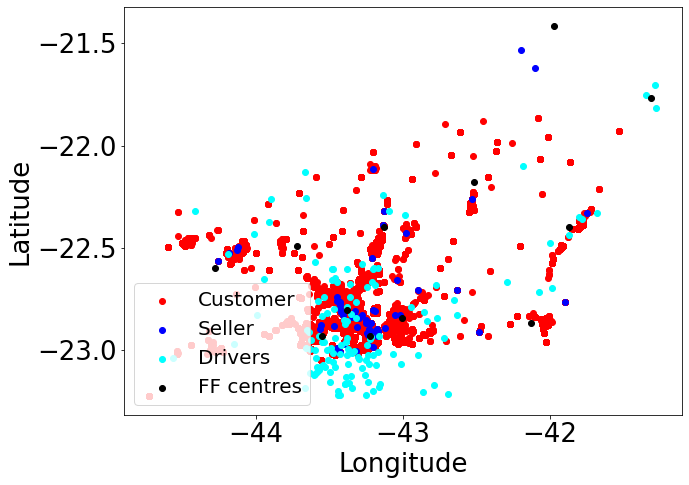

Const 3 146
Const 4 158
Const 5 17198
Const 6 17908
NUM_constraints 17908
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 98412 columns.
Reduced LP has 17908 rows, 10128 columns, and 64464 nonzeros.
Presolve time = 0.09 sec. (39.69 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.583592
Iteration:   221   Dual objective     =             8.086958
Iteration:   552   Dual objective     =             8.828805
Iteration:   754   Dual objective     =             9.117585
Iteration:   985   Dual objective     =             9.305725
Iteration:  1164   Dual objective     =             9.398748
Iteration:  1329   Dual

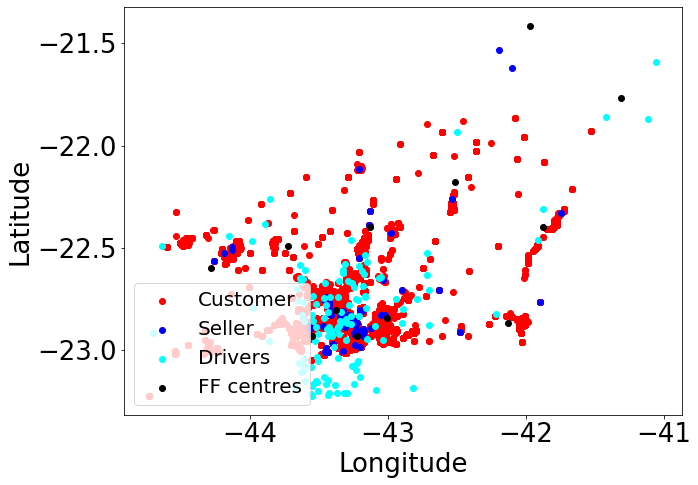

Const 3 140
Const 4 152
Const 5 17336
Const 6 18052
NUM_constraints 18052
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 88944 columns.
Reduced LP has 18052 rows, 10128 columns, and 64752 nonzeros.
Presolve time = 0.08 sec. (37.94 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.096430
Iteration:   232   Dual objective     =             7.735603
Iteration:   565   Dual objective     =             8.500840
Iteration:   909   Dual objective     =             8.838209
Iteration:  1173   Dual objective     =             9.020290
Iteration:  1388   Dual objective     =             9.108051
Iteration:  1563   Dual

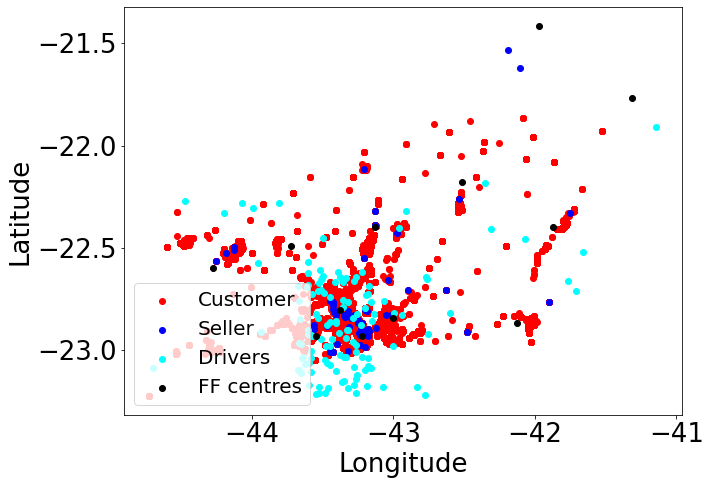

Const 3 140
Const 4 152
Const 5 16400
Const 6 17077
NUM_constraints 17077
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 89412 columns.
Reduced LP has 17077 rows, 9660 columns, and 61476 nonzeros.
Presolve time = 0.11 sec. (36.97 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.622533
Iteration:   255   Dual objective     =             8.738681
Iteration:   587   Dual objective     =             9.360813
Iteration:   775   Dual objective     =             9.590109
Iteration:   943   Dual objective     =             9.757584
Iteration:  1182   Dual objective     =             9.872882
Iteration:  1474   Dual 

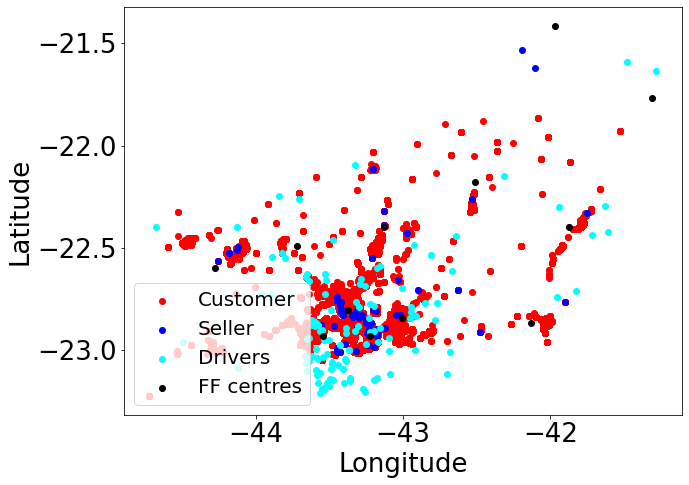

Const 3 130
Const 4 142
Const 5 13462
Const 6 14017
NUM_constraints 14017
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 76176 columns.
Reduced LP has 14017 rows, 8076 columns, and 50868 nonzeros.
Presolve time = 0.06 sec. (30.95 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.249518
Iteration:   239   Dual objective     =             7.508997
Iteration:   520   Dual objective     =             7.860368
Iteration:   720   Dual objective     =             8.042629
Iteration:   869   Dual objective     =             8.212902
Iteration:  1127   Dual objective     =             8.316775
Iteration:  1336   Dual 

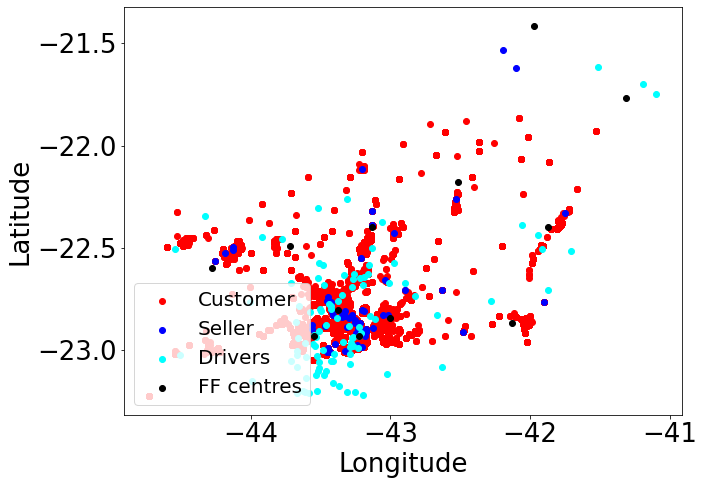

Const 3 114
Const 4 126
Const 5 9294
Const 6 9676
NUM_constraints 9676
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 57228 columns.
Reduced LP has 9676 rows, 5808 columns, and 35760 nonzeros.
Presolve time = 0.04 sec. (22.37 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             4.023021
Iteration:   210   Dual objective     =             6.105341
Iteration:   454   Dual objective     =             6.665896
Iteration:   656   Dual objective     =             7.017913
Iteration:   829   Dual objective     =             7.251015
Iteration:  1005   Dual objective     =             7.307790
Iteration:  1172   Dual obje

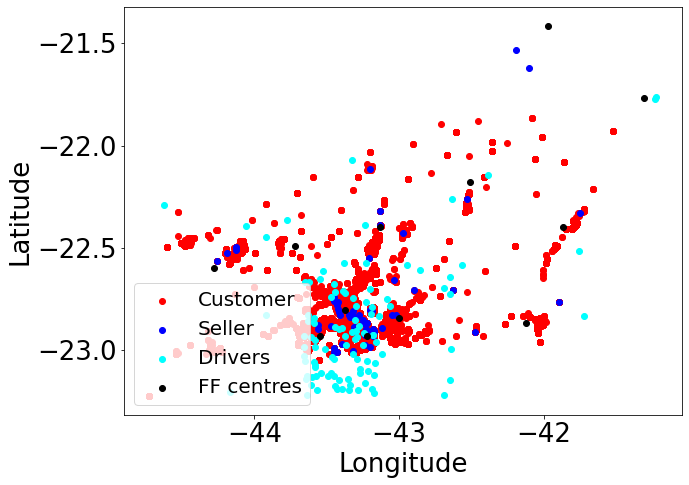

Const 3 119
Const 4 131
Const 5 11387
Const 6 11856
NUM_constraints 11856
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 62424 columns.
Reduced LP has 11856 rows, 6912 columns, and 43248 nonzeros.
Presolve time = 0.05 sec. (25.80 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.097336
Iteration:   237   Dual objective     =             8.129208
Iteration:   506   Dual objective     =             8.806714
Iteration:   669   Dual objective     =             9.085411
Iteration:   844   Dual objective     =             9.242987
Iteration:  1030   Dual objective     =             9.303425
Iteration:  1203   Dual 

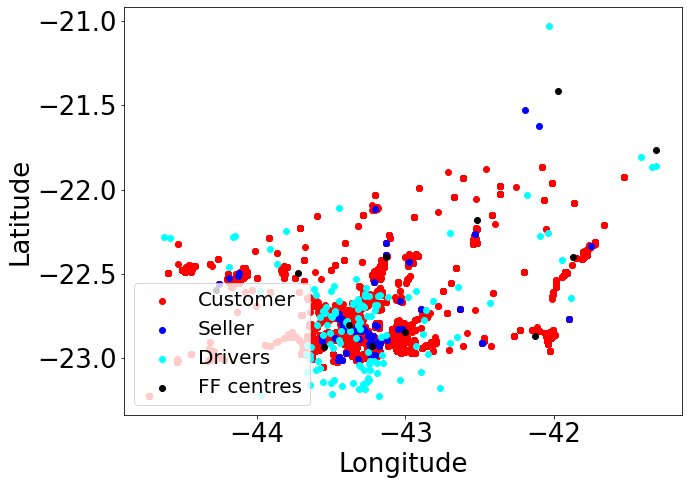

Const 3 139
Const 4 151
Const 5 15319
Const 6 15951
NUM_constraints 15951
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 88428 columns.
Reduced LP has 15951 rows, 9108 columns, and 57660 nonzeros.
Presolve time = 0.07 sec. (35.54 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.514023
Iteration:   253   Dual objective     =             7.756448
Iteration:   594   Dual objective     =             8.473545
Iteration:   809   Dual objective     =             8.940509
Iteration:  1018   Dual objective     =             9.119559
Iteration:  1266   Dual objective     =             9.176125
Iteration:  1472   Dual 

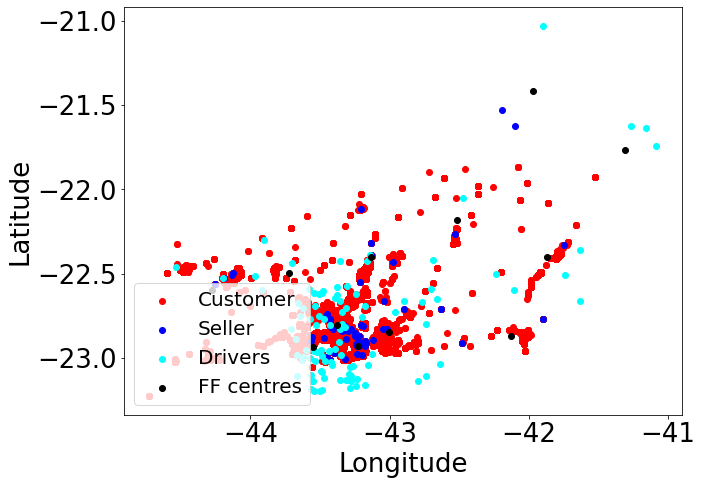

Const 3 112
Const 4 124
Const 5 8788
Const 6 9149
NUM_constraints 9149
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 55068 columns.
Reduced LP has 9149 rows, 5532 columns, and 33924 nonzeros.
Presolve time = 0.05 sec. (21.36 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             4.382815
Iteration:   209   Dual objective     =             6.039551
Iteration:   346   Dual objective     =             6.519044
Iteration:   540   Dual objective     =             6.733150
Iteration:   685   Dual objective     =             6.868042
Iteration:   857   Dual objective     =             6.960747
Iteration:  1044   Dual obje

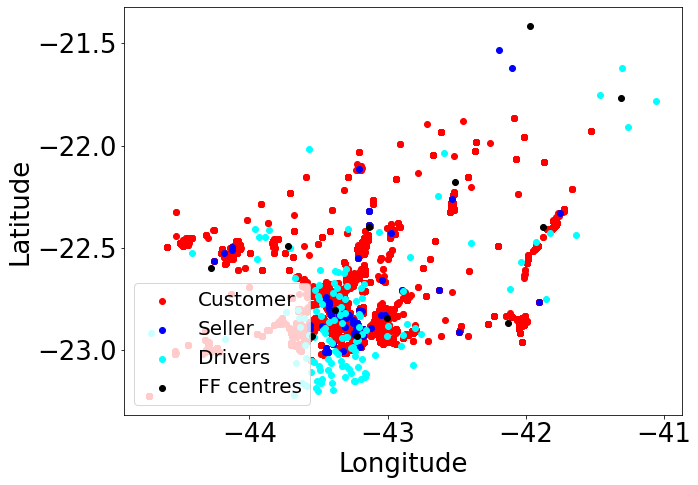

Const 3 143
Const 4 155
Const 5 16787
Const 6 17480
NUM_constraints 17480
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 93864 columns.
Reduced LP has 17480 rows, 9888 columns, and 62928 nonzeros.
Presolve time = 0.11 sec. (38.31 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             4.458908
Iteration:   261   Dual objective     =             6.922646
Iteration:   587   Dual objective     =             7.508427
Iteration:   856   Dual objective     =             8.032519
Iteration:  1055   Dual objective     =             8.119116
Iteration:  1279   Dual objective     =             8.318237
Iteration:  1481   Dual 

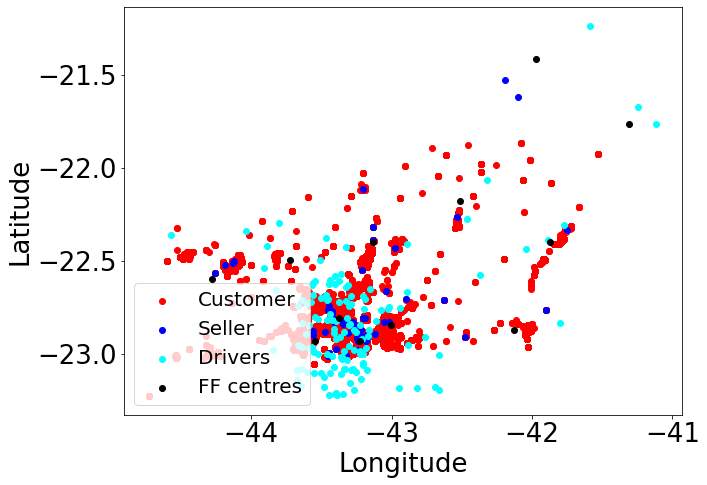

Const 3 150
Const 4 162
Const 5 19146
Const 6 19937
NUM_constraints 19937
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 103944 columns.
Reduced LP has 19937 rows, 11148 columns, and 71412 nonzeros.
Presolve time = 0.13 sec. (43.03 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.286104
Iteration:   262   Dual objective     =             7.530754
Iteration:   589   Dual objective     =             8.087582
Iteration:   975   Dual objective     =             8.529784
Iteration:  1177   Dual objective     =             8.731540
Iteration:  1426   Dual objective     =             8.877911
Iteration:  1651   Dua

In [ ]:
Gini_Index_List=[]
Avg_Distance_List=[]
Income_Gap_List=[]
spatial_inequality_list=[]
Name_list=[]
Income_sum_lis=[]
num_drivers=[]
income_lis_lis=[]
import copy




def sanityCheck(weights):
    for i in range(len(weights)):
        last_pos_index=-1
        neg_value=0
        for j in range(len(weights[0])):
            assert weights[i][j]>-1e-5
            if weights[i][j]<0:
                neg_value+=weights[i][j]
                weights[i][j]=0
            elif weights[i][j]>0:
                last_pos_index=j
        weights[i][last_pos_index]+=neg_value
    return weights


configParser.read(configFilePath)
number_of_runs=int(configParser.get('dataset-generation','number_of_runs'))
random_seed=int(configParser.get('dataset-generation','random_seed'))

dis_type=["random","low_income_dist","round_robin","vanilla_max","vanilla_maxmin","fair_algo"]
Name_dis_types=["Random","LIPA","RoundRobin","MCCA","MCCA-L","FairAssign"]
colors=['Indigo','Blue','Cyan','Green','Orange','Red']

indexs_allowed=[0,1,2,3,4,5]
indexs_allowed=[3,5]

fraction_list=[]
for i in range(number_of_runs):


    f = open("result.txt", "w")


    new_drivers,cities=driver_generation(i+random_seed)

    if len(new_drivers)<sum(lower_cap):
        print("Lower number of drivers generated")
        print(len(new_drivers), sum(lower_cap))
        continue

    result=fair_clustering(new_drivers,centre)

    num_samples = len(new_drivers)
    num_centres = len(centre)

    




    #Probability Distribution output from cplex
    print(num_samples,num_centres)
    lpp_prob_dis=np.reshape(result['assignment'][:num_samples*num_centres],(-1,num_centres))
    lpp_prob_dis=sanityCheck(copy.deepcopy(lpp_prob_dis))
    print(lpp_prob_dis)
    np.savetxt("foo.csv", lpp_prob_dis, delimiter=",")
    f = open("result.txt", "w")
    for point in range(num_samples):
        f.write(str(point)+" ")
        for c in range(num_centres):
            f.write(str(round(lpp_prob_dis[point][c],2))+" ")
        f.write("\n")


    print("Everything solved, graphs start")
    income_lis_lis=[]
    

    for j in indexs_allowed:
        tup=inequality2(cities,fair_type=dis_type[j],lpp_prob_dis=lpp_prob_dis)
        print(Name_dis_types[j])
        tup2 = helper_func(tup[2],new_drivers)
        spat=spatial_inequality(tup2[1],tup2[2],tup2[3],new_drivers)
        print("Gin Index: ",tup[0])
        print("Avg distance: ",tup[1])
        print("Income Gap: ", tup2[0])
        print("Spatial Inequality Index: ", spat)
        print("Run number",i)
        Gini_Index_List.append(tup[0])
        Avg_Distance_List.append(tup[1])
        Income_Gap_List.append(tup2[0])
        spatial_inequality_list.append(spat)
        Name_list.append(Name_dis_types[j])
        Income_sum_lis.append(tup[3])
        num_drivers.append(num_samples)
        income_lis_lis.append(tup[4])
        if j==3:
            base=tup2[3]
        if j==5:
            fair=tup2[3]


    '''
    tup=inequality2(cities,fair_type="random")
    print("Random Distribution")
    tup2 = helper_func(tup[2],new_drivers)
    spat=spatial_inequality(tup2[1],tup2[2],tup2[3],new_drivers)
    print("Gin Index: ",tup[0])
    print("Avg distance: ",tup[1])
    print("Income Gap: ", tup2[0])
    print("Spatial Inequality Index: ", spat)
    Gini_Index_List.append(tup[0])
    Avg_Distance_List.append(tup[1])
    Income_Gap_List.append(tup2[0])
    spatial_inequality_list.append(spat)
    Name_list.append('Random')
    Income_sum_lis.append(tup[3])
    num_drivers.append(num_samples)
    income_lis.append(lis)


    tup=inequality2(cities,fair_type="low_income_dist",lpp_prob_dis=lpp_prob_dis)
    print("Low Income Distribution")
    tup2 = helper_func(tup[2],new_drivers)
    spat=spatial_inequality(tup2[1],tup2[2],tup2[3],new_drivers)
    print("Gin Index: ",tup[0])
    print("Avg distance: ",tup[1])
    print("Income Gap: ", tup2[0])
    print("Spatial Inequality Index: ", spat)
    Gini_Index_List.append(tup[0])
    Avg_Distance_List.append(tup[1])
    Income_Gap_List.append(tup2[0])
    spatial_inequality_list.append(spat)
    Name_list.append('Low Income')
    Income_sum_lis.append(tup[3])
    num_drivers.append(num_samples)



    tup=inequality2(cities,fair_type="round_robin")
    print("Round Robin Distribution")
    tup2 = helper_func(tup[2],new_drivers)
    spat=spatial_inequality(tup2[1],tup2[2],tup2[3],new_drivers)
    print("Gin Index: ",tup[0])
    print("Avg distance: ",tup[1])
    print("Income Gap: ", tup2[0])
    print("Spatial Inequality Index: ", spat)
    Gini_Index_List.append(tup[0])
    Avg_Distance_List.append(tup[1])
    Income_Gap_List.append(tup2[0])
    spatial_inequality_list.append(spat)
    Name_list.append('Round Robin')
    Income_sum_lis.append(tup[3])
    num_drivers.append(num_samples)

    
    
    
    tup=inequality2(cities,fair_type="fair_algo",lpp_prob_dis=lpp_prob_dis)
    print("Fair Algo")
    tup2 = helper_func(tup[2],new_drivers)
    spat=spatial_inequality(tup2[1],tup2[2],tup2[3],new_drivers)
    fair=tup2[3]
    print("Gin Index: ",tup[0])
    print("Avg distance: ",tup[1])
    print("Income Gap: ", tup2[0])
    print("Spatial Inequality Index: ", spat)
    Gini_Index_List.append(tup[0])
    Avg_Distance_List.append(tup[1])
    Income_Gap_List.append(tup2[0])
    spatial_inequality_list.append(spat)
    Name_list.append('Fair Algo')
    Income_sum_lis.append(tup[3])
    num_drivers.append(num_samples)

    tup=inequality2(cities,fair_type="vanilla_max")
    print("Vanilla with Max Cap")
    tup2 = helper_func(tup[2],new_drivers)
    spat=spatial_inequality(tup2[1],tup2[2],tup2[3],new_drivers)
    base=tup2[3]
    print("Gin Index: ",tup[0])
    print("Avg distance: ",tup[1])
    print("Income Gap: ", tup2[0])
    print("Spatial Inequality Index: ", spat)
    Gini_Index_List.append(tup[0])
    Avg_Distance_List.append(tup[1])
    Income_Gap_List.append(tup2[0])
    spatial_inequality_list.append(spat)
    Name_list.append('Vanilla_Max')
    Income_sum_lis.append(tup[3])
    num_drivers.append(num_samples)

    tup=inequality2(cities,fair_type="vanilla_maxmin")
    print("Vanilla with MaxMin Cap")
    tup2 = helper_func(tup[2],new_drivers)
    spat=spatial_inequality(tup2[1],tup2[2],tup2[3],new_drivers)
    print("Gin Index: ",tup[0])
    print("Avg distance: ",tup[1])
    print("Income Gap: ", tup2[0])
    print("Spatial Inequality Index: ", spat)
    Gini_Index_List.append(tup[0])
    Avg_Distance_List.append(tup[1])
    Income_Gap_List.append(tup2[0])
    spatial_inequality_list.append(spat)
    Name_list.append('Vanilla_MaxMin')
    Income_sum_lis.append(tup[3])
    num_drivers.append(num_samples)

    '''
    # lorenz(income_lis_lis,Name_dis_types,colors)
    # lorenz_special_arr=[1,3]
    # lorenz([income_lis_lis[lorenz_ind] for lorenz_ind in lorenz_special_arr],[Name_dis_types[lorenz_ind] for lorenz_ind in lorenz_special_arr],  [colors[lorenz_ind] for lorenz_ind in lorenz_special_arr])

    fraction_worse_off = fraction(base,fair,new_drivers)
    fraction_list.append(fraction_worse_off)
    print(fraction_worse_off)
    # print("Fraction of drivers with increase in income:", fraction_worse_off[0])
    # print("Fraction of drivers with decrease in income:", fraction_worse_off[1])


    All_Income=pd.DataFrame({'Dist Type':Name_list,'Gini': Gini_Index_List, 'Avg Dist':Avg_Distance_List,'Income_Gap':Income_Gap_List,'spatial_index':spatial_inequality_list})
    print(All_Income.groupby('Dist Type').mean())
    print()
    print(All_Income.groupby('Dist Type').max())
    print()
    print(All_Income.groupby('Dist Type').min())
    print()












In [ ]:

# # fair_assignment(lpp_prob_dis,new_drivers)

# dd=pd.DataFrame(lpp_prob_dis)
# dd=dd.round(4)
# dd.to_csv("foo.csv")
# lpp_prob_dis1=dd.values
# arr=dd.sum(axis = 1, skipna = True).values
# for i in range(num_samples):
#     if arr[i]!=1.0 :
#         for j in range(num_centres):
#             if lpp_prob_dis1[i][j]!=0.0:
#                 lpp_prob_dis1[i][j]=lpp_prob_dis1[i][j]-(arr[i]-1.0)
#                 break



# dd=pd.DataFrame(lpp_prob_dis)
# dd=dd.round(4)
# dd.to_csv("foo1.csv")
# print("HELL")
# arr=dd.sum(axis = 1, skipna = True).values
# arr1=dd.sum(axis = 0, skipna = True).values
# print(arr1)

# # arr
# print("HELL")

# print(lpp_prob_dis1)
# fair_assignment(lpp_prob_dis,new_drivers)
# print("HELL")



# # lpp_prob_dis.tofile('foo.csv',sep=',',format='%10.5f')

In [ ]:
# print(fraction_list)
from statistics import mean
greater_than_threshold=[40,35,30,25,20,15,10,5,0]
lesser_than_threshold=[0,-5,-10,-15,-20,-25,-30,-35,-40]
greater_than_matrix=[[0 for j in range(len(fraction_list))] for i in range(len(greater_than_threshold))]
lesser_than_matrix=[[0 for j in range(len(fraction_list))] for i in range(len(lesser_than_threshold))]
for i in range(len(fraction_list)):
    for j in range(len(greater_than_threshold)):
        val=(fraction_list[i]>=greater_than_threshold[j]).sum()/len(fraction_list[i])
        greater_than_matrix[j][i]=val
for i in range(len(fraction_list)):
    for j in range(len(lesser_than_threshold)):
        val=(fraction_list[i]<lesser_than_threshold[j]).sum()/len(fraction_list[i])
        lesser_than_matrix[j][i]=val

avg_greater_than=[]
avg_lesser_than=[]
for i in range(len(greater_than_matrix)):
    avg_greater_than.append(sum(greater_than_matrix[i])/len(greater_than_matrix[i]))
for i in range(len(lesser_than_matrix)):
    avg_lesser_than.append(sum(lesser_than_matrix[i])/len(lesser_than_matrix[i]))
# print(np.array(greater_than_matrix))
# print(np.array(lesser_than_matrix))
# print(np.array(avg_greater_than))
# print(np.array(avg_lesser_than))


print(greater_than_threshold+lesser_than_threshold)

Change_df=pd.DataFrame({'Change': greater_than_threshold+lesser_than_threshold,'Val':avg_greater_than+avg_lesser_than})
print(Change_df)

# temp_np_array2=np.append(temp_np_array2,temp_np_array,axis=0)
# print(temp_np_array2)

[40, 35, 30, 25, 20, 15, 10, 5, 0, 0, -5, -10, -15, -20, -25, -30, -35, -40]
    Change       Val
0       40  0.338672
1       35  0.369853
2       30  0.407599
3       25  0.442326
4       20  0.467309
5       15  0.495769
6       10  0.523273
7        5  0.543940
8        0  0.621622
9        0  0.378378
10      -5  0.319994
11     -10  0.303065
12     -15  0.278712
13     -20  0.253268
14     -25  0.230035
15     -30  0.198111
16     -35  0.150967
17     -40  0.111483


In [ ]:

All_Income=pd.DataFrame({'Dist Type':Name_list,'Gini': Gini_Index_List, 'Avg Dist':Avg_Distance_List,'Income_Gap':Income_Gap_List,'spatial_index':spatial_inequality_list,'Income_sum':Income_sum_lis})

print(sum(lower_cap))





All_Income=All_Income.replace("Low Income Distribution","Robinhood")
configParser.read(configFilePath)
print("State: ",configParser.get('dataset-generation','state'))
print("Equal_to_or_not: ",configParser.get('dataset-generation','equal_to'))
print("num_ffc_center: ",configParser.get('dataset-generation','num_ffc_center'))
print("Grid Size: ",configParser.get('dataset-generation','grid_length'),configParser.get('dataset-generation','grid_width'))
print("Fair Distance: ",configParser.get('fairness-constraint','fair_distance'))
print("Alpha_fair: ",configParser.get('fairness-constraint','alpha_fair'))
print("number_of_runs: ",configParser.get('dataset-generation','number_of_runs'))
print()
print("Avg Num of Drivers: ",np.mean(np.array(num_drivers)))


print()
print(All_Income.groupby('Dist Type').mean().round(4))
print()
print(All_Income.groupby('Dist Type').max())
print()
print(All_Income.groupby('Dist Type').min())
print()
configParser.read(configFilePath)
fair_distance=int(configParser.get('fairness-constraint','fair_distance'))
# print(fair_distance)
# print(All_Income)

69
State:  RJ
Equal_to_or_not:  1
num_ffc_center:  12
Grid Size:  7 7
Fair Distance:  15
Alpha_fair:  1e-2
number_of_runs:  10

Avg Num of Drivers:  121.3

              Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                          
FairAssign  0.1626     0.253       1.176         0.0738   10132.219
MCCA        0.2823     0.181       1.090         0.0929   10091.151

             Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                         
FairAssign  0.193      0.27        1.72         0.0964    10133.65
MCCA        0.369      0.20        2.26         0.1933    10146.63

             Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                         
FairAssign  0.127      0.24        0.72         0.0555    10130.04
MCCA        0.228      0.16        0.34         0.0313     9838.98



In [ ]:
lorenz([2,3,4],[5,6,7])

TypeError: lorenz() missing 1 required positional argument: 'colors'

In [ ]:
# print("Average distance between the warehouses and drivers over all the days:",average_distance(inequality2(cities,)[2],label))
# print("Average distance between the warehouses and drivers over all the days:",average_distance(inequality2(cities,1,driver_df1)[2],label))
# print("Average distance between the warehouses and drivers over all the days:",average_distance(inequality2(cities,1,driver_df)[2],label))
